<a href="https://colab.research.google.com/github/abiraaaaaaf/Cattle-Detection/blob/main/Faster_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Cow detection (standing or sitting)

Fariba Lotfi.
Date: 29/10/2022

Cattle Dataset (Cattle images standing or sitting): 
* 245 training 
* 35 validation

**Main Problem:** Cow Detection (Standing or Sitting)

**YOLO vs. Faster RCNN**

Faster RCNN:

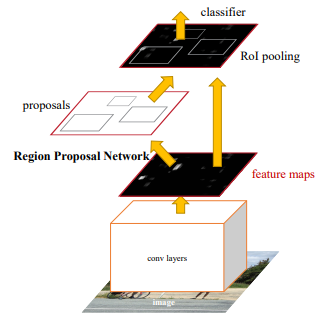

Faster RCNN pipeline:

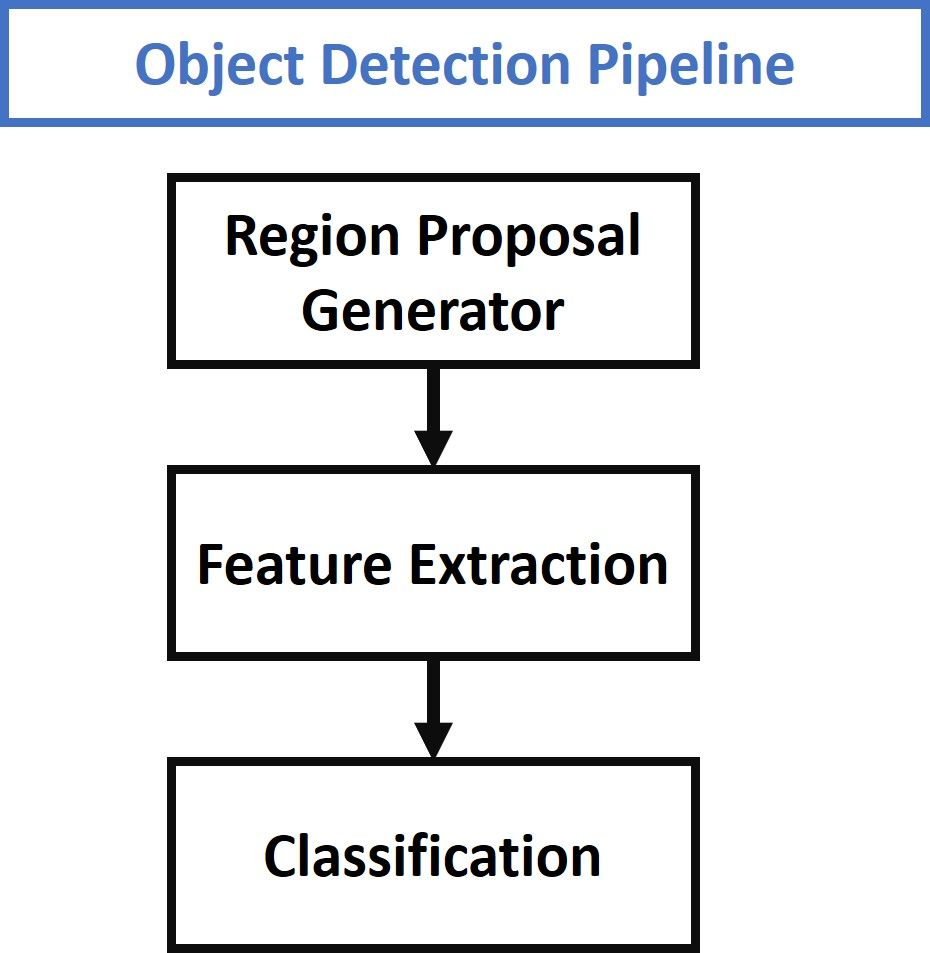

Check if GPU is available:

In [ ]:
import torch

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
import os
import random
import numpy as np
import shutil

### Dataset Information

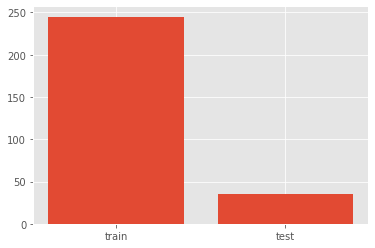

In [ ]:
import matplotlib.pyplot as plt
 
x = np.arange(2)
plt.bar(x, height=[245,35])
plt.xticks(x, ['train','test']);
plt.style.use('ggplot')
plt.show()

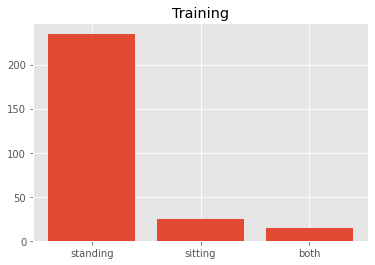

In [ ]:
import matplotlib.pyplot as plt
 
x = np.arange(3)
plt.bar(x, height=[235,25,15])
plt.xticks(x, ['standing','sitting','both']);
plt.style.use('ggplot')
plt.title('Training')
plt.show()

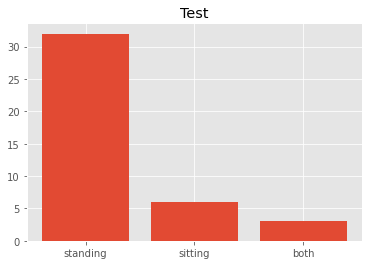

In [ ]:
import matplotlib.pyplot as plt
 
x = np.arange(3)
plt.bar(x, height=[32,6,3])
plt.xticks(x, ['standing','sitting','both']);
plt.style.use('ggplot')
plt.title('Test')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
!ls "/content/drive/My Drive/cattle"

Mounted at /content/drive/
data  data.rar


In [ ]:
!unrar x -r -o- "/content/drive/My Drive/cattle/cattle.rar" '/content/drive/My Drive/cattle/cattle/'


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/My Drive/cattle/cattle.rar

Creating    /content/drive/My Drive/cattle/cattle                     OK
Creating    /content/drive/My Drive/cattle/cattle/data                OK
Creating    /content/drive/My Drive/cattle/cattle/data/train          OK
Creating    /content/drive/My Drive/cattle/cattle/data/train/images   OK
Extracting  /content/drive/My Drive/cattle/cattle/data/train/images/0000f2101250b009_jpg.rf.650930ad1ba122dd906e10184d24d011.jpg       0%  OK 
Extracting  /content/drive/My Drive/cattle/cattle/data/train/images/0004fa3aa5bdb9ff_jpg.rf.594a07a17d4048a11f785f1f94757e1f.jpg       0%  OK 
Extracting  /content/drive/My Drive/cattle/cattle/data/train/images/0006dbac092b5a91_jpg.rf.854326f490f8c0d91d1eb22638262fce.jpg       0%  OK 
Extracting  /content/drive/My Drive/cattle/cattle/data/train/images/0007844dce093b4b_jpg.rf.0652d6658fa1013f7781f18c632741e5

Preparing the dataset:

In [ ]:
import os
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from PIL import Image
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time

In [ ]:
import fnmatch
import glob

def generate_target(dirpath): 

    #num_files = len(fnmatch.filter(os.listdir(dirpath), '*.txt'))
    boxes = []
    labels = []
    for filename in glob.glob(dirpath + '*.txt'):
        with open(os.path.join(os.getcwd(), filename), 'r') as f: # open in readonly mode  
            lines = f.readlines()
            for line in lines:
                #print(line)
                line = line.rstrip('\n').split(' ')
                labels.append(int(line[0]))
                boxes.append([416*float(line[1]) - (416*float(line[3])/2), 416*float(line[2]) - (416*float(line[4])/2) , 416*float(line[1]) + (416*float(line[3])/2), 416*float(line[2]) + (416*float(line[4])/2)])

    boxes = torch.as_tensor(boxes, dtype=torch.float32) 
    #print(boxes)
    labels = torch.as_tensor(labels, dtype=torch.int64) 
    
    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    
    return target

def plot_image_from_output(img, annotation):
    
    img = img.cpu().permute(1,2,0)
    
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 1 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')

        ax.add_patch(rect)

    plt.show()

In [ ]:
class MaskDataset(object):
    def __init__(self, transforms, path):
        '''
        path: path to train folder or test folder
        '''
        # define the path to the images and what transform will be used
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))


    def __getitem__(self, idx): #special method
        # load images ad masks
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'txt'
        img_path = os.path.join(self.path, file_image)
        
        if 'train' in self.path:
            label_path = "/content/drive/My Drive/cattle/cattle/data/train/labels/"
        else:
            label_path = "/content/drive/My Drive/cattle/cattle/data/valid/labels/"

        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self): 
        return len(self.imgs)

data_transform = transforms.Compose([  # transforms.Compose : a class that calls the functions in a list consecutively
        transforms.ToTensor() # ToTensor : convert numpy image to torch.Tensor type
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform, '/content/drive/My Drive/cattle/cattle/data/train/images/')
test_dataset = MaskDataset(data_transform, '/content/drive/My Drive/cattle/cattle/data/valid/images/')

print(len(dataset), len(test_dataset))

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, collate_fn=collate_fn)

245 35


In [ ]:
def get_model_instance_segmentation(num_classes):
  
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
num_classes = 2 # standing vs. sitting

model = get_model_instance_segmentation(num_classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
num_epochs = 10
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

In [ ]:
print('----------------------train start--------------------------')
for epoch in range(num_epochs):
    start = time.time()
    model.train()
    i = 0    
    epoch_loss = 0
    print(len(data_loader))
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations) 
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        epoch_loss += losses
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

----------------------train start--------------------------
62
epoch : 1, Loss : 112.79353332519531, time : 101.09458613395691
62
epoch : 2, Loss : 95.09561920166016, time : 98.92532181739807
62
epoch : 3, Loss : 90.12130737304688, time : 99.06679916381836
62
epoch : 4, Loss : 88.83211517333984, time : 99.1734688282013
62
epoch : 5, Loss : 86.60063171386719, time : 98.89120864868164
62
epoch : 6, Loss : 84.3432388305664, time : 99.02369594573975
62
epoch : 7, Loss : 83.64877319335938, time : 98.9253568649292
62
epoch : 8, Loss : 81.17373657226562, time : 98.61225461959839
62
epoch : 9, Loss : 80.22746276855469, time : 99.13045692443848
62
epoch : 10, Loss : 80.07015228271484, time : 98.92957067489624


In [ ]:
torch.save(model.state_dict(),f'model_{num_epochs}.pt')

In [ ]:
model.load_state_dict(torch.load(f'model_{num_epochs}.pt'))

<All keys matched successfully>

In [ ]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [ ]:
with torch.no_grad(): 
    # batch size of the test set = 4
    for imgs, annotations in test_data_loader:
        imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(model, imgs, 0.5)
        print(pred)
        break

[{'boxes': tensor([[2.7713e+02, 1.4546e+02, 4.1307e+02, 4.1600e+02],
        [3.1279e+02, 0.0000e+00, 4.1446e+02, 2.1813e+02],
        [3.9679e+00, 6.0443e+01, 1.2719e+02, 4.1542e+02],
        [3.3436e+02, 7.4648e+01, 4.1269e+02, 2.5947e+02],
        [3.0728e+02, 2.0777e+02, 4.1369e+02, 3.6192e+02],
        [2.1017e+00, 1.3964e+02, 8.7784e+01, 3.3709e+02],
        [2.2282e+02, 0.0000e+00, 4.1044e+02, 1.8036e+02],
        [1.9924e+02, 2.1506e+02, 2.9680e+02, 4.0821e+02],
        [0.0000e+00, 7.7851e+00, 7.1905e+01, 2.5393e+02],
        [2.3871e+02, 2.7959e+02, 4.0271e+02, 3.7437e+02],
        [2.3282e+02, 2.1672e+02, 3.3017e+02, 4.0976e+02],
        [2.6124e+02, 2.0344e+02, 3.6276e+02, 4.0381e+02],
        [3.0492e+02, 1.6233e+02, 4.1551e+02, 3.0492e+02],
        [0.0000e+00, 2.1975e+02, 1.1325e+02, 4.1600e+02],
        [1.6642e+02, 2.1609e+02, 2.6385e+02, 4.0898e+02],
        [4.4620e+01, 1.0681e+01, 2.0805e+02, 1.8617e+02],
        [7.8492e+01, 1.6849e+02, 1.9403e+02, 3.8482e+02],
   

In [ ]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model, im, 0.1)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

100%|██████████| 9/9 [00:04<00:00,  1.86it/s]


In [ ]:
import torch
import numpy as np

def get_batch_statistics(outputs, targets, iou_threshold):
    """ Compute true positives, predicted scores and predicted labels per sample """
    batch_metrics = []
    for sample_i in range(len(outputs)):

        if outputs[sample_i] is None:
            continue

        output = outputs[sample_i] # predict
        # pred_boxes = output['boxes']
        # pred_scores = output['scores']
        # pred_labels = output['labels']

        true_positives = torch.zeros(output['boxes'].shape[0])   # 예측 객체 개수
 
        annotations = targets[sample_i]  # actual
        target_labels = annotations['labels'] if len(annotations) else []
        if len(annotations):    # len(annotations) = 3
            detected_boxes = []
            target_boxes = annotations['boxes']

            for pred_i, (pred_box, pred_label) in enumerate(zip(output['boxes'], output['labels'])): # 예측값에 대해서..

                # If targets are found break
                if len(detected_boxes) == len(target_labels): # annotations -> target_labels
                    break

                # Ignore if label is not one of the target labels
                if pred_label not in target_labels:
                    continue

                iou, box_index = bbox_iou(pred_box.unsqueeze(0), target_boxes).max(0)   # box_index : 실제 어떤 바운딩 박스랑 IoU 가 가장 높은지 index
                if iou >= iou_threshold and box_index not in detected_boxes: # iou만 맞으면 통과?
                    true_positives[pred_i] = 1
                    detected_boxes += [box_index]  # 예측된거랑 실제랑 매핑해서 하나씩 index 채움
        batch_metrics.append([true_positives, output['scores'], output['labels']])
    return batch_metrics

def bbox_iou(box1, box2, x1y1x2y2=True):
    """
    Returns the IoU of two bounding boxes
    """
    if not x1y1x2y2:
        # Transform from center and width to exact coordinates
        b1_x1, b1_x2 = box1[:, 0] - box1[:, 2] / 2, box1[:, 0] + box1[:, 2] / 2
        b1_y1, b1_y2 = box1[:, 1] - box1[:, 3] / 2, box1[:, 1] + box1[:, 3] / 2
        b2_x1, b2_x2 = box2[:, 0] - box2[:, 2] / 2, box2[:, 0] + box2[:, 2] / 2
        b2_y1, b2_y2 = box2[:, 1] - box2[:, 3] / 2, box2[:, 1] + box2[:, 3] / 2
    else:
        # Get the coordinates of bounding boxes
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    # get the corrdinates of the intersection rectangle
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)
    # Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(inter_rect_y2 - inter_rect_y1 + 1, min=0)
    # Union Area
    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)

    return iou

def ap_per_class(tp, conf, pred_cls, target_cls):
    """ Compute the average precision, given the recall and precision curves.
    Source: https://github.com/rafaelpadilla/Object-Detection-Metrics.
    # Arguments
        tp:    True positives (list).
        conf:  Objectness value from 0-1 (list).
        pred_cls: Predicted object classes (list).
        target_cls: True object classes (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """

    # Sort by objectness
    i = torch.argsort(-conf)
    tp, conf, pred_cls = tp[i], conf[i], pred_cls[i]

    # Find unique classes
    unique_classes = torch.unique(target_cls)   # 2가 거의 예측안됨
    print(unique_classes)
    # Create Precision-Recall curve and compute AP for each class
    ap, p, r = [], [], []
    for c in unique_classes:
        i = pred_cls == c
        n_gt = (target_cls == c).sum()  # Number of ground truth objects
        n_p = i.sum()  # Number of predicted objects

        if n_p == 0 and n_gt == 0:
            continue
        elif n_p == 0 or n_gt == 0:
            ap.append(0)
            r.append(0)
            p.append(0)
        else:
            # Accumulate FPs and TPs
            fpc = torch.cumsum(1 - tp[i],-1)
            tpc = torch.cumsum(tp[i],-1)

            # Recall
            recall_curve = tpc / (n_gt + 1e-16)
            r.append(recall_curve[-1])

            # Precision
            precision_curve = tpc / (tpc + fpc)
            p.append(precision_curve[-1])

            # AP from recall-precision curve
            ap.append(compute_ap(recall_curve, precision_curve))

    # Compute F1 score (harmonic mean of precision and recall)

    p, r, ap = torch.tensor(np.array(p)), torch.tensor(np.array(r)), torch.tensor(np.array(ap))
    f1 = 2 * p * r / (p + r + 1e-16)

    return p, r, ap, f1, unique_classes

def compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.
    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([0.0], precision, [0.0]))
    print

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

In [ ]:
sample_metrics = []
print(len(preds_adj_all))
for batch_i in range(len(preds_adj_all)):
    sample_metrics += get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated

precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

9
tensor([0, 1])
mAP : 0.16964215606293542
AP : tensor([0.0000, 0.3393], dtype=torch.float64)


Since I only trained it for **10 epochs**, the **mAP is not very high**.
This result took a lot of time on Google Colab and we need to **train it for more epochs**.